# Bitflipping Environment with DQN (+HER)

### Environment

In [17]:
import numpy as np

class BitFlippingEnv():
    def __init__(self, n:int, seed:int=None):
        if n <= 0:
            raise ValueError("n must be positive integer")
        self.n = n  # number of bits
        if seed is not None:
            self.seed = np.random.seed(seed)
        # action is the bit to flip
        self.action_space = np.arange(n)        
        
    def reset(self):
        self.state = np.random.randint(2, size=self.n)  # random initial state
        self.goal = np.random.randint(2, size=self.n)   # random goal
        
        # goal should be different to initial state
        while np.sum(self.state == self.goal) == self.n:   
            self.goal = np.random.randint(2, size=self.n)
        return self.state, self.goal

    def step(self, state, action):
        # action is the bit to flip
        next_state = np.copy(state)
        next_state[action] = 1 - next_state[action] # flip

        # return next_state, reward, done
        if self.done(next_state, self.goal):
            return next_state, 0, True   
        else:
            return next_state, -1, False
    
    def render(self, state):
        print("State: ", state)
            
    def done(self, state, goal):
        # done if n bits are correct
        return np.sum(state == goal) == self.n

In [28]:
## Testing environment
n = 4
env = BitFlippingEnv(n)

state, goal = env.reset()
print("Initial state:", state, "\t Goal:", goal)
for i in range(1000):
    action = np.random.randint(0,n)
    state, reware, done = env.step(state, action)
    env.render(state)
    if done:
        print("----------------- DONE in ", i+1, "steps")
        break

Initial state: [0 1 0 0] 	 Goal: [1 0 0 0]
State:  [0 0 0 0]
State:  [0 0 1 0]
State:  [1 0 1 0]
State:  [1 1 1 0]
State:  [1 1 0 0]
State:  [1 1 0 1]
State:  [1 1 1 1]
State:  [1 1 0 1]
State:  [1 1 0 0]
State:  [1 0 0 0]
----------------- DONE in  10 steps


### DQN

In [29]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
from dqn_BitflipAgent import Agent

n = 13
env = BitFlippingEnv(n)
agent = Agent(state_size=n, action_size=n, seed=0)

In [ ]:
def dqn(n_episodes=5000, max_t=500, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    success = []
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores

    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state, goal = env.reset()
        score = 0
        
        for t in range(max_t):
            state_goal = np.concatenate((state, goal))  # input for agent: s_g
            
            action = agent.act(state_goal, eps)
            next_state, reward, done = env.step(state, action)
            
            next_state_goal = np.concatenate((next_state, goal))  # s'_g
            agent.step(state_goal, action, reward, next_state_goal, done)
            
            state = next_state
            score += reward
            if done:
                success.append(1)
                break            
        if not done:
            success.append(0)
            
        # save most recent score
        scores_window.append(score)       
        scores.append(score)              
        
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    
    return scores, success

scores, success = dqn()


Episode 100	Average Score: -491.12
Episode 200	Average Score: -497.94
Episode 300	Average Score: -494.49
Episode 400	Average Score: -500.00
Episode 500	Average Score: -492.91
Episode 600	Average Score: -496.72
Episode 700	Average Score: -490.06
Episode 800	Average Score: -495.85
Episode 900	Average Score: -500.00
Episode 1000	Average Score: -500.00
Episode 1100	Average Score: -496.97
Episode 1200	Average Score: -500.00
Episode 1300	Average Score: -500.00
Episode 1400	Average Score: -495.84
Episode 1500	Average Score: -491.47
Episode 1600	Average Score: -497.93
Episode 1700	Average Score: -500.00
Episode 1800	Average Score: -500.00
Episode 1874	Average Score: -500.00

In [ ]:
# save numpy array as csv file
#from numpy import asarray
#from numpy import savetxt
# define data
#data = asarray([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
# save to csv file
#savetxt('data.csv', data, delimiter=',')

# load numpy array from csv file
#from numpy import loadtxt
# load array
#data = loadtxt('data.csv', delimiter=',')
# print the array
#print(data)

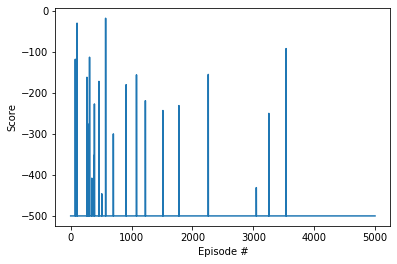

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [26]:
import pandas as pd

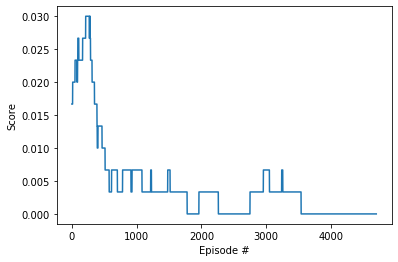

In [27]:
# plot success
N = 300
rolling_avg = pd.Series(success).rolling(window = N).mean().iloc[N-1:].values

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(rolling_avg)), rolling_avg)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [11]:
# saving trained network
#torch.save(agent.qnetwork_local.state_dict(), 'trained_checkpoint_n12_ep5k.pth')

### Testing trained agent on Bitflipping

In [21]:
n = 12
env = BitFlippingEnv(n)
agent = Agent(state_size=n, action_size=n, seed=0)

# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('trained_checkpoint_n12_ep5k.pth'))

s = 0
m = 100
for i in range(m):
    state, goal = env.reset()
    #print("Goal:", goal, "\t Initial state:", state)
    #print("difference: ", n - np.sum(state == goal))
    for j in range(n):
        state_goal = np.concatenate((state, goal))

        action = agent.act(state_goal, 0)
        state, reward, done = env.step(state, action)
        
        if done:
            s += 1
            #print("final state:", state, "steps:", j+1)
            break 
            
print("Success rate {}/{}".format(s,m))

Success rate 98/100


In [22]:
a = scores
b = success